In [2]:
import sympy as sy
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# ORIGINAL PARAMETERS #

p = 8.3e-5 #'' # units mup1 per millisecond (mup1 production rate)
w = 32 # unitless (scale factor for pH difference)
j = 100 #'' # per millisecond (methionine unbinding rate)
kd = 8993 # (methionine dissociation constant)
h = j / kd #'' # per micromolar per millisecond (methionine binding rate)
f = .25 #'' # per millisecond (recycling rate)
Ae = 47 # micrometers^3 (endosomal membrane surface area)
Ap = 314 # micrometers^3 (plasma membrane surface area)
u = 1 # per millisecond (ubiquitination rate)
a = 10 #'' # per micromolar per millisecond (art 1 binding rate)
b = 1 # per millisecond (deubiquitination rate)
d = .002 #'' # per millisecond (degradation rate)
n = 0.1 #'' # per millisecond (endocytosis rate)
V = 523 # micrometers^3 (volume of cytoplasm)
vmax = 174333.33 # micromolars*micrometers^3 per millisecond (maximal rate of methionine metabolism)
        # can range from 0 to infty
Km = 350 #'' # micromolars (methionin michaelis-menten constant)
# vmax = 8.8e3
# Km = 2.5
Me = .1


In [57]:
"""OLD PARAMETERS"""

# parameters (filled in the ones I think would be the same or similar to Fur4)
p = 8.3e-5 #'' # units mup1 per millisecond (mup1 production rate)
h = 100 / 8993 #'' # per micromolar per millisecond (methionine binding rate)
w = 32 # unitless (scale factor for pH difference)
j = 100 #'' # per millisecond (methionine unbinding rate)
f = .25 #'' # per millisecond (recycling rate)
Ae = 47 # micrometers^3 (endosomal membrane surface area)
Ap = 314 # micrometers^3 (plasma membrane surface area)
u = 1 # per millisecond (ubiquitination rate)
a = 1e-5 #'' # per micromolar per millisecond (art 1 binding rate)
b = 1 # per millisecond (deubiquitination rate)
d = .002 #'' # per millisecond (degradation rate)
n = 0.1 #'' # per millisecond (endocytosis rate)
V = 523 # micrometers^3 (volume of cytoplasm)
vmax = 8.8e3 #'' # micromolars*micrometers^3 per millisecond (maximal rate of methionine metabolism)
Km = 2.5 #'' # micromolars (methionine michaelis-menten constant)
Me = 1

In [292]:
# change a parameter
vmax = 174333.33
Km = 350
a = .65
j = 100
kd = 2188
h = j / kd


In [293]:
# substitution into M to get equation for bisection method

# establish sympy variables
P, Pm, Pa, Pu, E, Em, Ea, Eu, M = sy.symbols("P, Pm, Pa, Pu, E, Em, Ea, Eu, M")

# steady states computed previously
steady_states = {P : p*w*(M*a**2*d*h + M*a*d*h*j + a**2*b*f*w + a**2*d*f*w + 2*a*b*f*j*w + 2*a*d*f*j*w + b*f*j**2*w + d*f*j**2*w)/(M*a**2*d*h**2*(M + Me*w)),
                 Pm : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a**2*d*h),
                 Pa : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a*d*h*u),
                 Pu : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a*d*h*n),
                 E : Ap*p*w*(a*b + a*d + b*j + d*j)/(Ae*M*a*d*h),
                 Em : Ap*p*(b + d)/(Ae*a*d),
                 Ea : Ap*p*(b + d)/(Ae*d*u),
                 Eu : Ap*p/(Ae*d)}

# substitutions
dM = -(h/w)*M*((Ap / V)*P + (Ae / V)*E) + (j + u)*((Ae / V)*Em + (Ap / V)*Pm) - vmax*M/(V*(Km + M))  # M 

new_dM = dM.subs(steady_states)
new_dM = sy.simplify(new_dM)
new_dM

(-174326.285240923*M**3 - 5578311.98849477*M**2*Me + 193028.358545425*M**2 + 1759834452.45819*M*Me + 66696942.5039711*M + 615898623350.976*Me)/(M*(523.0*M**2 + 16736.0*M*Me + 183050.0*M + 5857600.0*Me))

519.5723187935073


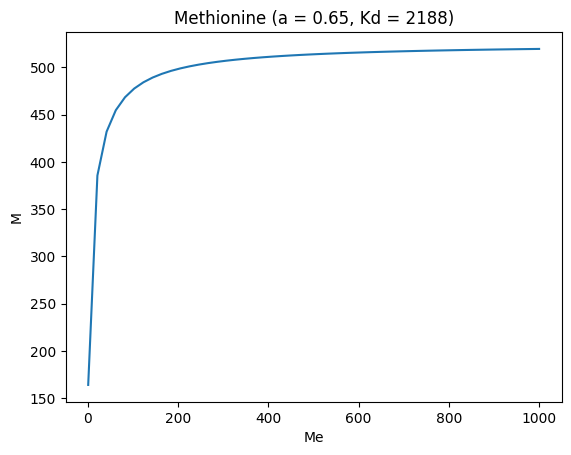

In [295]:
# dM_func = sy.lambdify(M, new_dM)

# # plot dM against M
# x_vals = np.linspace(0.001, 200, 1000)
# plt.plot(x_vals, dM_func(x_vals))
# plt.plot(x_vals, np.zeros_like(x_vals))
# plt.ylim(-100, 500)
# plt.show()

Me = sy.symbols("Me")

def bisection_M(m, dM=sy.lambdify(Me, (-Ap*M*p*(Km + M)*(M*a**2*d*h + M*a*d*h*j + a**2*b*f*w + a**2*d*f*w + 2*a*b*f*j*w + 2*a*d*f*j*w + a*h*(M + Me*w)*(a*b + a*d + b*j + d*j) + b*f*j**2*w + d*f*j**2*w) + Ap*p*(Km + M)*(M + Me*w)*(j + u)*(M*a*d*h + M*a*h*(b + d) + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w) - M**2*a**2*d*h*vmax*(M + Me*w))/(M*V*a**2*d*h*(Km + M)*(M + Me*w))), 
                p=8.3e-5, h=135, w=32, j=100, f=.25, Ae=47, Ap=314, u=1,
                a=1e-5, b=1, d=.002, n=0.1, V=523, vmax=8.8e3, Km=2.5, bounds=[0, 4000], maxiter=10000):
    """Solving for the steady state of M at a given methionine value Me
        
        Parameters:
        - Me (float): amount of extracellular methionine
        - dM (sympy lambda function): differential equation in terms of extracellular methionine input as independent variable
        - parameters (floats, optional): set to the values we currently have, can be changed as needed
        - bounds (list, optional): initial upper and lower bound for the bisection method"""
    # save dM with substitutions for all other variables (computed in steady_states_simplification.ipynb)
    dM = sy.simplify(dM(m))
    dM_eq = sy.lambdify(M, dM)

    # assign variables for beginning, end, and midpoint
    x0, x1 = bounds[0], bounds[1]

    # use a loop to continue splitting the interval until you find 0
    for i in range(maxiter):
        # assign midpoint
        xmid = (x0 + x1) / 2    # so that it updates every time

        # check function at midpoint
        if np.isclose(dM_eq(xmid), 0):
            return xmid
        elif (dM_eq(xmid) > 0):   # if greater than zero, it should replace the left endpoint
            x0 = xmid
        else:                  # if less than zero, it should replace right endpoint
            x1 = xmid
    
    # raise runtime error if it doesn't converge
    print(m)
    raise RuntimeError(f"Failed to converge in {maxiter} steps")

# graph to see if it works for wide range of values
print(bisection_M(1000))

mvals = np.linspace(1, 1000, 50)
plt.plot(mvals, [bisection_M(m) for m in mvals])
plt.title(f"Methionine (a = {a}, Kd = {kd})")
plt.xlabel("Me")
plt.ylabel("M")
plt.savefig(f"Images/varying_parameters/normal_except_a={a}_Kd={kd}.png")
plt.show()

In [1]:
"""Define the model"""
from mup1_model import bisection_M

def mup1_model(t, y, parameters):
    """Function coding the Mup1 trafficking model.
    
        Parameters:
        - y (array, list): values of P, Pm, Pa, Pu, E, Em, Ea, Eu, M"""

    P, Pm, Pa, Pu, E, Em, Ea, Eu, M = y 
    p, w, j, kd, f, Ae, Ap, u, a, b, d, n, V, vmax, Km, Me = parameters    # unpack for readability
    h = j / kd

    # define the differential equations
    dy = [
        p - h*Me*P - (h/w)*M*P + j*Pm + f*(Ae/Ap)*E,                       # P
        h*Me*P + (h/w)*M*P - j*Pm - a*Pm,                                  # Pm
        a*Pm - u*Pa,                                                       # Pa
        u*Pa - n*Pu,                                                       # Pu
        n*(Ap/Ae)*Pu - f*E + b*Eu - (h/w)*E*M + j*Em,                      # E
        (h/w)*E*M - a*Em - j*Em,                                           # Em
        a*Em - u*Ea,                                                       # Ea
        -b*Eu + u*Ea - d*Eu,                                               # Eu
        -(h/w)*M*((Ap / V)*P + (Ae / V)*E) + (j + u)*((Ae / V)*Em + (Ap / V)*Pm) - vmax*M/(V*(Km + M))  # M 
        ]

    return dy

def mup1_steady_states(parameters):
    """Function to find the steady states of the Mup1 trafficking model.
    
        Parameters:
        - parameters (array, list): values of the parameters"""
    p, w, j, kd, h, f, Ae, Ap, u, a, b, d, n, V, vmax, Km, Me = parameters    # unpack for readability
    M = bisection_M(Me)

    steady_states = { 'P' : p*w*(M*a**2*d*h + M*a*d*h*j + a**2*b*f*w + a**2*d*f*w + 2*a*b*f*j*w + 2*a*d*f*j*w + b*f*j**2*w + d*f*j**2*w)/(M*a**2*d*h**2*(M + Me*w)),
                     'Pm' : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a**2*d*h),
                     'Pa' : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a*d*h*u),
                     'Pu' : p*(M*a*d*h + a*b*f*w + a*d*f*w + b*f*j*w + d*f*j*w)/(M*a*d*h*n),
                      'E' : Ap*p*w*(a*b + a*d + b*j + d*j)/(Ae*M*a*d*h),
                     'Em' : Ap*p*(b + d)/(Ae*a*d),
                     'Ea' : Ap*p*(b + d)/(Ae*d*u),
                     'Eu' : Ap*p/(Ae*d)}
    

    return sum(steady_states.values()) + M

In [2]:
"""AI suggested parameter ranges"""

parameter_ranges = [
    [8.3e-6, 8.3e-4],     # p: Mup1 production rate – production rates can vary over orders of magnitude due to transcriptional and translational regulation, environmental cues, and promoter strength.
    [10, 100],            # w: pH scale factor – this is a unitless scaling factor, and while its exact biological interpretation may vary, a range of 1 order of magnitude allows for exploratory analysis without being too speculative.
    [10, 1000],           # j: Methionine unbinding rate – binding and unbinding kinetics often vary by 1–2 orders of magnitude depending on temperature, affinity, and conformational state.
    [1000, 90000],        # kd: Dissociation constant – dissociation constants vary widely across protein-ligand systems; range chosen to reflect affinities from high (1 μM) to low (90 μM) binding strength.
    # h is derived from j/kd, so it should not be varied independently – vary j and kd instead
    [0.025, 2.5],         # f: Recycling rate – endosomal recycling rates can vary depending on the type of cargo, regulatory proteins, and metabolic state; 1 order of magnitude captures plausible biological fluctuation.
    [20, 100],            # Ae: Endosomal surface area – endosomal sizes (and hence surface areas) differ based on maturation stage and cell size; this range allows for ~5x variation while remaining realistic for yeast cells.
    [100, 1000],          # Ap: Plasma membrane surface area – reflects variability in yeast cell size; 3–10 μm diameter cells yield surface areas within this range.
    [0.1, 10],            # u: Ubiquitination rate – enzymatic tagging rates are context-dependent, influenced by E3 ligase concentration and substrate type; range spans 2 orders of magnitude.
    [1, 100],             # a: Art1 binding rate – ART protein interactions with transporters can vary widely depending on substrate conformation and signaling state; large range allows for nonlinearity exploration.
    [0.1, 10],            # b: Deubiquitination rate – affected by availability of deubiquitinases and substrate accessibility; same logic as for ubiquitination rate.
    [0.0002, 0.02],       # d: Degradation rate – protein degradation is generally slow, but this range captures variation due to stress conditions, proteasome targeting, or trafficking dynamics.
    [0.01, 1],            # n: Endocytosis rate – strongly regulated and responsive to signaling, nutrient levels, and surface cargo density; up to 100-fold variability is plausible.
    [200, 1000],          # V: Cytoplasmic volume – yeast cells range from ~30 to ~100 fL; cytoplasmic volume varies with cell cycle stage and environmental conditions.
    [1e4, 1e6],           # vmax: Max methionine metabolism rate – reflects possible differences in metabolic enzyme expression, post-translational regulation, and methionine flux capacity.
    [50, 1000],           # Km: Michaelis constant – Km values commonly vary across enzymes and contexts; this range includes both high-affinity (low Km) and low-affinity (high Km) scenarios.
    [0.1, 500],           # Me: Extracellular methionine concentration – based on reported yeast media compositions (from starvation up to rich media); range spans near-zero to saturating conditions.
]


parameter_ranges_2 = [[1e-6, 1e-3],   # p: mup1 production rate (y)
                      [10, 100],      # w: pH scale factor
                      [10, 1000],     # j: methionine unbinding rate
                      [1000, 100000], # kd: methionine dissociation constant
                      [0.01, 1],      # f: recycling rate
                      [10, 100],      # Ae: endosomal membrane surface area
                      [100, 1000],    # Ap: plasma membrane surface area
                      [0.1, 10],      # u: ubiquitination rate (a)
                      [1, 100],       # a: art1 binding rate (p)
                      [0.1, 10],      # b: deubiquitination rate
                      [1e-4, 0.01],   # d: degradation rate (z)
                      [0.01, 1],      # n: endocytosis rate (g)
                      [100, 1000],    # V: cytoplasmic volume
                      [1e4, 1e6],     # vmax: maximal methionine metabolism rate
                      [10, 1000],     # Km: methionine Michaelis-Menten constant
                      [.1, 500]       # Me: extracellular methionine
]



In [ ]:
"""Parameter Sensitivity Analysis"""
from SALib.sample import saltelli, sobol as sobol_sample
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm

# set up problem
problem = {
    'num_vars': 15,
    'names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km'],
    'bounds': parameter_ranges
}

# generate samples using Saltelli sampler
param_values = sobol_sample.sample(problem, 128)

# loop over sample inputs and run model
Y = np.zeros([param_values.shape[0]])

# set up for use with solve_ivp
# Choose initial conditions
y0 = [0, 0, 0, 0, 0, 0, 0, 0, 0]

# Time span for integration
t_span = (0, 50)
t_eval = np.linspace(*t_span, 10)

for i, X in enumerate(tqdm(param_values, desc="Running model")):
    sol = solve_ivp(mup1_model, t_span, y0, args=(X,), t_eval=t_eval)
    # have it save the total amount of mup1
    Y[i] = sum(sol.y[:, -1])

# compute sensitivity indices using model outputs
Si = sobol.analyze(problem, Y)

Si.plot()
plt.show()


In [ ]:
# Store results in a list
results = [{'timestamp': '2025-06-19T10:56:32.497337', 
            'seed': None, 
            'sensitivity_indices': {'mu': [1.0978665942541703, 1.0851931734006008e-06, 0.10479488942297797, -2.0159325680521616, -0.02143248250496083, -0.06098611003412613, 0.09686167308559247, 0.03180786520859847, -0.9226258646638608, 0.00021498965720665318, -3.600319016334209e-07, 0.13047729381061474, -0.6726308265287009, -0.8000933948624768, 0.048257237183364825, 0.3995054573371986], 
                                    'mu_star': [1.0978665942541703, 1.2301721229335192e-06, 0.10479488942297797, 2.0159325680521616, 0.07812901498637817, 0.06098611003412613, 0.09686167308559247, 0.03180787210638027, 0.953622000030093, 0.00021671975505486093, 3.6003190173261525e-07, 0.13047729381061474, 0.6726308856602912, 0.8000933948624768, 0.048257237183364825, 0.3995054573371986], 
                                    'mu_star_conf': [1.8560658552228189, 1.0426458267263852e-06, 0.08413171401420166, 3.516662325164585, 0.05449786359560706, 0.03801589357785989, 0.07880390390026773, 0.04271226218838121, 0.9927790876622197, 0.0004414706910871279, 5.212200080096482e-07, 0.1473433265243125, 1.196185022560689, 1.2025414901538014, 0.050796908879682204, 0.5830165284585572], 
                                    'sigma': [5.460744469127985, 3.539567080219277e-06, 0.24858564292972013, 10.93683669948031, 0.17512174815517237, 0.12266518552045458, 0.23521785638238882, 0.14450626350236215, 3.3412453826989057, 0.001220990982578263, 1.4294729151248763e-06, 0.38848594738373055, 3.641157064112175, 3.7042698486163257, 0.13716212329720298, 1.5487152591378874]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:02:44.961774', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.31983105189826205, -9.428424072137614e-09, 0.13221482359512826, -1.7153830457095713, 0.7254595879542716, -0.08136941739330167, 0.6103514169594899, 0.3219758914090119, -0.2547668184042228, 1.8802851876752057e-06, -6.777149410754022e-07, 0.11816543928288693, -0.4657664869336063, -0.9240703157803625, 0.4954128093821484, 0.31953617516427635], 
                                     'mu_star': [0.31983105189826205, 1.3248259010026642e-07, 0.13221482957630018, 1.7153830994435006, 0.748691338645769, 0.08136941739330167, 0.610351514025209, 0.3219759345264019, 0.25869167197877335, 1.9059465174101722e-06, 6.77714941076378e-07, 0.11816543928288693, 0.4657667142238671, 0.9240703157803625, 0.4954128093821484, 0.31953617516427635], 
                                     'mu_star_conf': [0.29839841139121925, 9.434374366864377e-08, 0.12813890820903406, 1.9134218932889966, 1.2119405963419287, 0.07207551649243221, 0.5913971004901549, 0.48417965552980124, 0.21079175531741032, 2.817144198140066e-06, 8.934828028459809e-07, 0.10872576876536375, 0.7169361841870913, 0.9780848719248992, 0.5417093414121895, 0.4929582593577602], 
                                     'sigma': [0.9157109779089438, 3.034295663909402e-07, 0.3576634050927632, 5.589892638480653, 3.4218579818512675, 0.21143723241274423, 1.7583561767271865, 1.520380237239274, 0.6400938993409814, 7.954463897136222e-06, 2.5730563828413196e-06, 0.29931342200004785, 1.9461208231984486, 2.7882601615535565, 1.5701501235358872, 1.3257011277942607]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:06:25.313279', 
            'seed': None, 
            'sensitivity_indices': {'mu': [1.8194588664970819, 8.431443746488059e-06, 0.34599965500489677, -0.643715298746547, 0.27398941551104034, -0.03144335800444942, 2.0130255979493588, 0.020617183972674195, -0.23283703282560497, 6.375280874770364e-07, -2.47522350481536e-06, 0.15266827579014933, -0.531375190742546, -0.48932747872230015, 1.6829212035956647, 0.38424565887062545], 
                                     'mu_star': [1.8194588664970819, 8.44958878814465e-06, 0.3459996804868605, 0.643715298746547, 0.3273545742225071, 0.03144335800444942, 2.01302565541379, 0.020617247931852788, 0.2688024138819368, 7.143518521669753e-07, 2.4752235048169863e-06, 0.15266827579014933, 0.5313756360843104, 0.48932747872230015, 1.6829212035956647, 0.38424565887062545], 
                                     'mu_star_conf': [3.1208143073192525, 1.3630107070940413e-05, 0.5879297317796714, 0.9080752715924513, 0.48479560958572965, 0.021545456349141897, 3.902735280851506, 0.017049586926173914, 0.45878165844875834, 1.1160662996968532e-06, 4.602770758619781e-06, 0.17070328234123913, 1.0582980770037649, 0.5237828000248009, 2.1722558966810204, 0.4387857978671009], 
                                     'sigma': [8.1652228091954, 3.415875110437142e-05, 1.6043011774158131, 2.514815484149166, 1.5988425523323633, 0.07655521106577283, 10.607133468397961, 0.04843523542752808, 1.289322865100198, 3.2490665906982695e-06, 1.3408344288605674e-05, 0.48944830304948517, 2.9859051086171213, 1.5195467271817291, 6.364214508452977, 1.2639713353675217]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:10:18.959902', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.21311937270707323, 2.7938224547291997e-05, 0.13464903514642496, -0.07187266729903137, 0.01290728300230294, -0.02703070774455009, 0.14935225578185976, 0.04806273985312968, -0.06533902122053264, -4.307801474637432e-07, -1.2942687757473316e-06, 0.11883813107936995, -0.025711693607129056, -0.06612980708684453, 0.057950910361098174, 0.020350874477528924], 
                                    'mu_star': [0.21311937270707323, 3.204417452384711e-05, 0.13464905214601802, 0.07187266729903137, 0.08870677755315255, 0.02703070774455009, 0.14935225578185976, 0.048062744361392636, 0.08014917672569567, 9.416099069077743e-07, 1.294268775750874e-06, 0.11883813107936995, 0.02571190063037057, 0.06612980708684453, 0.05795091154985138, 0.020350874477528924], 
                                    'mu_star_conf': [0.13902759848400137, 6.106141784786861e-05, 0.16319455661082724, 0.03999678684006248, 0.10697569139447607, 0.022587030052531976, 0.15581032291569263, 0.032113948225430324, 0.08075071964329548, 1.2185544708788866e-06, 2.287835665078388e-06, 0.12119740478016809, 0.044872555689102395, 0.0515973864429127, 0.07565719337778563, 0.016419577149265806], 
                                    'sigma': [0.42039499159049554, 0.00017025641689799703, 0.4255244386641648, 0.11110834253438635, 0.3055527389929187, 0.07364577295109266, 0.4655238650595247, 0.11875951828238301, 0.22284251273481923, 3.843049955716379e-06, 6.840125610682236e-06, 0.3557721110188359, 0.13200479736153106, 0.17880271815925586, 0.19887135357601907, 0.044901444104377575]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:15:06.619242', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.3366677178858109, -9.480411441928248e-07, 0.20448576875816674, -0.08568745148831329, -0.07074511018648344, -0.021547598904024908, 0.1818507517603852, 0.021429691836765127, -0.007474819519016318, -2.168064403082453e-07, -1.0031695685120269e-08, 0.030487472162510333, -0.1267889115399116, -0.2206451252293507, 0.01615291822504427, 0.10367860476246084], 
                                    'mu_star': [0.3366677178858109, 1.1757647348656677e-06, 0.20448588544762883, 0.08568745148831329, 0.07102094204343615, 0.021547598904024908, 0.1818507517603852, 0.021429691836765127, 0.021260959261086045, 2.1920782649354552e-07, 1.0031695882949896e-08, 0.030487472162510333, 0.1267890463436038, 0.2206451383825676, 0.01615295455079494, 0.10367860476246084], 
                                    'mu_star_conf': [0.4598010178246977, 2.0993097351654347e-06, 0.3429684515139567, 0.11253003130322103, 0.052292632128896684, 0.015442126795252847, 0.1448281970000985, 0.016246152772654763, 0.018879483383918462, 3.3113630398074686e-07, 1.7476214519005306e-08, 0.020192683254596878, 0.237707363156445, 0.26701543695459534, 0.010281187882359896, 0.12059559587895355], 
                                    'sigma': [1.1305383180494601, 5.9968524198984915e-06, 0.9556326280929867, 0.33890476932830804, 0.14653092619545943, 0.04715115907194113, 0.4537589203413388, 0.04470838134524375, 0.05400576752863473, 9.882524603408787e-07, 5.026950601456642e-08, 0.05768951687206959, 0.6792753823265738, 0.7445403742617075, 0.02867825713772908, 0.3727054757161615]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:18:38.704511', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.9452520673798158, 0.00027300335298985606, 0.10810623781106388, -1.5302502765988708, 0.24313441225671775, -0.011715722364775931, 0.0847196500148812, 0.033390323036463686, -0.19734747839341618, -2.7246312565158338e-06, -1.885467991595556e-08, 0.059231788362391624, -0.1288163672403703, -0.6096369005039591, 0.6694586385479375, 0.7441472932752698], 
                                    'mu_star': [0.9452520673798158, 0.00027332221701576625, 0.10810623781106388, 1.5302502765988708, 0.42932839110232224, 0.011715722364775931, 0.0847196500148812, 0.033390323036463686, 0.20318437548532994, 2.7685642729252184e-06, 1.8854680093075232e-08, 0.059231788362391624, 0.1288166841050931, 0.6096369317552054, 0.6694586385479375, 0.7441472932752698], 
                                    'mu_star_conf': [1.261833573503595, 0.000506944732173422, 0.09725940322050296, 2.4909345769370974, 0.5873168052172267, 0.009323664428122599, 0.06238308362626871, 0.055144110132308286, 0.21928604424756853, 5.655519932903278e-06, 3.1796039061993334e-08, 0.07029142713515991, 0.28179725017194013, 0.6882390656346167, 1.0246846088239392, 1.139646726562858], 
                                    'sigma': [3.4080199465359433, 0.001533573488466367, 0.3085490447413247, 8.232150778366098, 1.8134510981577503, 0.027518021604283086, 0.1919706246984924, 0.13876855785530415, 0.6398720361756178, 1.5466466611097438e-05, 9.461584851170963e-08, 0.2115267565772344, 0.7055879983362989, 2.1001467702722545, 3.104047726717269, 3.3788080578646245]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:23:42.737828', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.1926638551612678, 1.3010998786973426e-06, 0.8837925226927582, -0.13151133355648711, -0.09404554237098667, -0.04096427947398792, 0.10969721641283621, 0.007685081203739609, -0.06438623638879101, -1.670330419279688e-09, -1.3153633702327418e-06, 0.03236029123508374, -0.6081711155750139, -1.4431099156507623, 0.09126123302054709, 0.0770276383599637], 
                                    'mu_star': [0.1926638551612678, 1.4850142021680376e-06, 0.8837925682843116, 0.13151133355648711, 0.09442943339035959, 0.04096427947398792, 0.10969721641283621, 0.007685081203739609, 0.0742447038007656, 3.7436108089676185e-08, 1.315363370232808e-06, 0.03236029123508374, 0.6081713929311388, 1.4431099235815243, 0.09126123302054709, 0.0770276383599637], 
                                    'mu_star_conf': [0.14666231395472587, 1.949466647861802e-06, 1.523384530780135, 0.12832026888091425, 0.10246218566632527, 0.0445472533026466, 0.06203664455072272, 0.008609179905234165, 0.08832603011026655, 4.434777520426161e-08, 1.8191208157057463e-06, 0.02504600711662673, 1.0067530091126664, 2.3074897949327027, 0.09787956077717105, 0.07890250565386132], 
                                    'sigma': [0.36990614105059827, 6.603484516831711e-06, 4.493888007343049, 0.3921574691521321, 0.2728483229442998, 0.13493467737000475, 0.1872635228232828, 0.025416846435483566, 0.26372940238788517, 1.4003125142297633e-07, 5.463700786404648e-06, 0.06896545515090725, 3.393408370744427, 7.795867345381479, 0.2730725083764207, 0.23049089364908082]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:27:30.278815', 
            'seed': None, 
            'sensitivity_indices': {'mu': [4.062157877830038, 0.11591378111468369, 0.058024774381124966, -0.04097110532678509, 2.827555954202775, -0.039934686381549865, 0.4990972692018712, 0.021815751407849707, -0.10493161999725044, 0.0010313422282713974, -6.276419277934758e-09, 0.6268631974638856, -0.9850571902338717, -0.07783666615387479, 0.09712589093187554, 0.20481094120749346], 
                                    'mu_star': [4.062157877830038, 0.11591393874916661, 0.058024774381124966, 0.04097110532678509, 3.0286522770968105, 0.039934686381549865, 0.4990972740432435, 0.021815751407849707, 0.15167175628502516, 0.0010313978207242768, 6.276419277934758e-09, 0.6268631974638856, 0.985057707722259, 0.0778367006923175, 0.09712589093187554, 0.20481094120749346], 
                                    'mu_star_conf': [7.3363915661220815, 0.2158509644793931, 0.05688346244625618, 0.02887485394653805, 5.327568818898924, 0.040116798666488464, 0.7243265710262249, 0.02306522161115873, 0.09789707659492458, 0.001922488704229746, 8.641449442839464e-09, 1.0289085340342572, 1.5869651673629448, 0.07258992327418574, 0.10211570182913951, 0.172797242228489], 
                                    'sigma': [21.274151581537982, 0.6554243241774107, 0.16725623089703165, 0.08923568325956253, 16.04592566223838, 0.11253918744560479, 2.094236271687441, 0.05952288609260199, 0.3508912573394261, 0.005793538657732685, 2.4595868155836425e-08, 2.735412599123648, 4.958767014207254, 0.23555531246602918, 0.3611881855326098, 0.5304276543401503]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
           {'timestamp': '2025-06-19T11:30:42.078291', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.3136028462921433, 4.7921246755369864e-05, 0.05024432461605674, -0.06629600278031635, -0.02278753324711151, -0.08126423702695866, 0.07035824125722845, 0.010732453601991269, -0.17305467680514933, -6.233147646937956e-08, -1.357656173108786e-08, 0.053860868345427554, -0.0057250908165759305, -0.31978309694822754, 0.1533873633027311, 0.1578475855541612], 
                                    'mu_star': [0.3136028462921433, 4.8382575428204155e-05, 0.05024441485924665, 0.06629608673833323, 0.041202703963426214, 0.08126423702695866, 0.07035824125722845, 0.010732541665393173, 0.18303230284544036, 7.428462276075903e-08, 1.357656173108786e-08, 0.053860868345427554, 0.0057253678179633545, 0.31978309694822754, 0.1533873633027311, 0.1578475855541612], 
                                    'mu_star_conf': [0.20851268972804457, 8.962208727846438e-05, 0.04255974815257316, 0.028543957206079745, 0.026405816088384187, 0.05146050700661526, 0.04451060567200631, 0.008290143573915908, 0.27187645731636617, 1.183374831337615e-07, 1.712663472802613e-08, 0.06445395201107686, 0.006740304356661083, 0.48817519778169455, 0.12519207828176715, 0.12199077812532036], 
                                    'sigma': [0.6248162831099164, 0.0002717360253381189, 0.1263732481476393, 0.09473134923417613, 0.08779945535088836, 0.1451822118464348, 0.14056228206602, 0.02206283241608968, 0.734352152374964, 3.6153856987155195e-07, 5.0862755832696056e-08, 0.21847700079232923, 0.019129918539214853, 1.308737649895251, 0.41018782019738775, 0.36075415540153394]}, 
            'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}, 
            {'timestamp': '2025-06-19T11:34:59.111336', 
             'seed': None, 
             'sensitivity_indices': {'mu': [0.31897253556144783, 2.1335000171744053e-06, 0.18455233236567276, -1.1853187919312995, -0.015530042379512592, -0.0353694879519037, 0.2457729307775947, 0.05755088713917702, -0.3555704239704863, -4.731841440222762e-08, -3.8111461584533072e-06, 0.025516872944951578, -0.02274960510922645, -0.3606964661737582, 0.09898812012638006, 1.318152739812797], 
                                     'mu_star': [0.31897253556144783, 2.1842338414104193e-06, 0.18455233236567276, 1.1853187919312995, 0.03922205201421567, 0.0353694879519037, 0.24577296097139156, 0.05755088713917702, 0.380898228211234, 6.047708027383513e-08, 3.8111461584781897e-06, 0.025516872944951578, 0.022750010381005523, 0.3606964661737582, 0.09898812012638006, 1.318152739812797], 
                                     'mu_star_conf': [0.15753147027454936, 2.5587540229845194e-06, 0.17683278047683806, 2.070586604436306, 0.034540392461692916, 0.030287826897055267, 0.17477343407808107, 0.08136987891910501, 0.3483564870640739, 1.0311643875087934e-07, 7.71555334643885e-06, 0.017595171276260504, 0.020192669488620602, 0.2995942834221576, 0.11820682375284661, 1.884275230624758], 
                                     'sigma': [0.5235302437691592, 7.683653137763106e-06, 0.46533440219397393, 5.784037245579449, 0.10394931437306001, 0.08652546246063053, 0.5211300193418142, 0.22004804396346872, 0.9672344057772547, 2.9026387940662626e-07, 2.1426309333901282e-05, 0.05450615588726531, 0.06665064480433172, 0.8762126517554769, 0.3909397483618415, 6.017984637952225]}, 
             'parameter_names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me']}]


Starting multiprocessing


Running model in parallel:   0%|          | 0/1088 [00:00<?, ?it/s]

{'timestamp': '2025-06-30T12:36:54.655919', 'seed': None, 'sensitivity_indices': {'mu': [0.06379917333403853, 0.03128908706867695, 0.13859259269574528, -0.07655400788134514, 0.06405314229571309, -0.03957039005672311, 0.15379854220681466, -0.01261185148127647, -0.03313248396132101, 0.00948127123018435, 0.051394283202400845, 0.03241794607480348, -0.010345766960523698, -0.09764763829937217, 0.04860474318363811, 0.04574351319244129], 'mu_star': [0.12962457118441523, 0.11465005821387382, 0.2020020546521758, 0.1769061683429016, 0.2007690165153459, 0.15601236667266877, 0.17763977020533742, 0.13308817992884292, 0.14191922414529445, 0.1307387370674067, 0.14299189705174797, 0.140488500603768, 0.1294913327488197, 0.17457367256568201, 0.12479646271059873, 0.08889979757159187], 'mu_star_conf': [0.05148876971428197, 0.03875579301489372, 0.16817119368201489, 0.08623684419787904, 0.16162829566789036, 0.04797122283289624, 0.08180626084207752, 0.04641066262052717, 0.06631973967037619, 0.0487835963046899

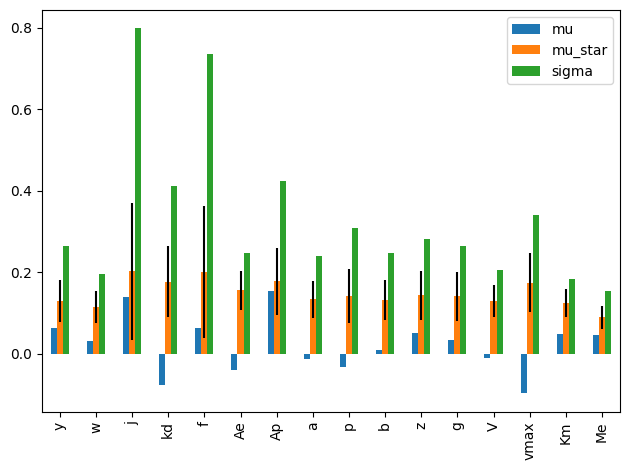

In [ ]:
"""Trying it again using multiprocessing"""

from multiprocessing import Pool
from SALib.sample import sobol as sobol_sample, morris as morris_sample
from SALib.analyze import sobol, morris
from scipy.integrate import solve_ivp
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

# set up problem
problem = {
    'num_vars': 16,
    'names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me'],
    'bounds': parameter_ranges
}

# generate samples using Saltelli sampler
param_values = sobol_sample.sample(problem, 32)

# loop over sample inputs and run model
Y = np.zeros([param_values.shape[0]])

def run_model(X):
    # set up for use with solve_ivp
    y0 = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    t_span = (0, 50)
    t_eval = np.linspace(*t_span, 10)
    
    sol = solve_ivp(mup1_model, t_span, y0, args=(X,), t_eval=t_eval)
    return sum(sol.y[:, -1])

print("Starting multiprocessing")
# Use multiprocessing to run the model in parallel
with Pool() as pool:
    # Use map instead of imap to maintain order
    Y = list(tqdm(pool.imap(run_model, param_values), 
                    total=len(param_values),
                    desc="Running model in parallel"))

# Convert to numpy array
Y = np.array(Y)

# compute sensitivity indices using model outputs
Si = morris.analyze(problem, param_values, Y)
print({'timestamp': datetime.now().isoformat(),
        'seed': None,
        'sensitivity_indices': {
            'mu': Si['mu'].tolist(),
            'mu_star': Si['mu_star'].tolist(),
            'mu_star_conf': Si['mu_star_conf'].tolist(),
            'sigma': Si['sigma'].tolist() if 'sigma' in Si else None,
        },
        'parameter_names': problem['names']})

Si.plot()
plt.tight_layout()
#plt.savefig("Images/sensitivity_analysis/morris_from_og_system_ai_params_3.png")
plt.show()

Running sobol_sample and morris.analyze

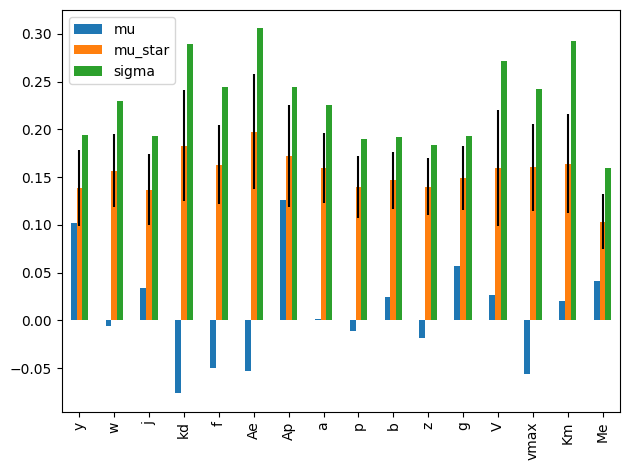

In [5]:
sobol_morris_results = [{'timestamp': '2025-06-30T11:17:17.735489', 'seed': None, 
                'sensitivity_indices': {'mu': [0.1021638299708506, -0.005648535307002132, 0.033665879891369856, -0.07649420426540983, -0.04986706933162051, -0.053078474104552735, 0.12614629708999522, 0.0015534710646411519, -0.011381217462377163, 0.02462202105050367, -0.0179744679246495, 0.05683858256143583, 0.027031074674994236, -0.05583881278652968, 0.02037397520429407, 0.0416858446612627], 
                                        'mu_star': [0.13905812594243025, 0.1568572305618472, 0.13682867652817818, 0.18271617111417907, 0.16313977254020667, 0.1976265864018134, 0.1720017838002368, 0.15942197265204747, 0.13956757138103512, 0.14654843324943811, 0.13973136529238236, 0.14912132982564388, 0.15915315504023061, 0.16023663475235184, 0.1640547931879993, 0.10335595719696537], 
                                        'mu_star_conf': [0.0398161882524916, 0.03803619071987918, 0.036853974416416295, 0.05813864674380702, 0.041547957183029484, 0.05981680254358724, 0.05311841291544242, 0.03664331477243101, 0.03270492608337005, 0.029884738800080028, 0.029846578398339926, 0.03385210358992289, 0.06064505730286691, 0.045795764582676875, 0.052064634997216516, 0.028931266984241418], 
                                        'sigma': [0.19382510653169882, 0.23018634952973377, 0.19310515688551125, 0.28964952924907905, 0.2446278383503312, 0.3058410655832339, 0.24442668271202525, 0.22530445390271087, 0.19002057822239385, 0.19145776599246003, 0.18337864712223356, 0.19318395360332516, 0.2718020741983004, 0.24210168763346873, 0.29234535034273207, 0.15911527984390378]}, 
                'parameter_names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'p', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me']},
                {'timestamp': '2025-06-30T12:08:38.419895', 'seed': None, 
                 'sensitivity_indices': {'mu': [0.09077033345123928, -0.04022252524409906, 0.04293289391964533, -0.05719135629491878, -0.04117180455316899, -0.029256386378761184, 0.0199549730262028, 0.021557221042322564, -0.019357957954266133, -0.0037107201077890366, -0.009270814887345807, 0.022361168603002947, -0.006312859745245977, -0.051105770659178325, -0.04638093957848646, 0.14628811911119546], 
                                         'mu_star': [0.10991300883725154, 0.14886224113857482, 0.1382180632746205, 0.1436873174675683, 0.12193273443021957, 0.12231589656565148, 0.10989299815634354, 0.1153586437669563, 0.12070746514622774, 0.10608221393142339, 0.11143652837860903, 0.11838487214177838, 0.1000118517307557, 0.12451943210109759, 0.20552784277805916, 0.16986782583946566], 
                                         'mu_star_conf': [0.03134353086645431, 0.06639222616425523, 0.05285659388712765, 0.08624231980604086, 0.039224392394171546, 0.03435218496582841, 0.02823737795779388, 0.029588849883621225, 0.03396002284903512, 0.02600205504867537, 0.026019468279616143, 0.03371676806438259, 0.02143910554378862, 0.04032162699884152, 0.1480846660507968, 0.14828241797181063], 
                                         'sigma': [0.1556563148897491, 0.31712854675079416, 0.27215574831214945, 0.3350247053446592, 0.18324074708773136, 0.19709066908693038, 0.15854115310129985, 0.16359634702327353, 0.18310291075609844, 0.14518769139505772, 0.155077843210445, 0.18551699193308513, 0.13638647450023342, 0.20278466385173782, 0.7137058072007094, 0.6353432304890527]},
                 'parameter_names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'p', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me']},
                {'timestamp': '2025-06-30T12:17:21.529104', 'seed': None, 
                 'sensitivity_indices': {'mu': [-0.015330239865788563, -0.13919944471587445, 0.14644921749407844, -0.17982915596695578, 0.03602402850739883, -0.13444706975788892, 0.15564288069440405, -0.075740067007957, -0.17278972720912386, -0.058094144707503924, -0.13576463099658478, -0.11775511705612321, -0.07332649005048522, -0.2634503400251991, 0.09745732435520456, 0.10693023738080196], 
                                         'mu_star': [0.21338545851378676, 0.20540152655575591, 0.2106881741202788, 0.2541427989718422, 0.16721480402517053, 0.20725834764530598, 0.25145750387753535, 0.2099008188532329, 0.2679446786948971, 0.23349704343430672, 0.23229981883544845, 0.2746809445528075, 0.16216585986844712, 0.3409750098184261, 0.20352691198624434, 0.14889333671606517], 
                                         'mu_star_conf': [0.22017842070321963, 0.1498072495984806, 0.21932800527633892, 0.2556706361158206, 0.12133771175982797, 0.16494628147771223, 0.2694920177896143, 0.12138468012368707, 0.2661476124437772, 0.18534946648671455, 0.26106172602193034, 0.3445492449904913, 0.09056404616078174, 0.39676876032687725, 0.16569566133549823, 0.15008368256130936], 
                                         'sigma': [0.9048295561084002, 0.6928159488934379, 0.9275852606801936, 0.9904896588343679, 0.5890676537350786, 0.6681511334606017, 1.2594200921600542, 0.580107394375395, 1.1754715692874909, 0.837095186229397, 1.045565052165544, 1.3494171017523375, 0.3909388888647376, 1.838202513825098, 0.657876200929061, 0.5853729300825605]}, 
                 'parameter_names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'p', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me']},
                {'timestamp': '2025-06-30T12:24:39.507158', 'seed': None, 
                 'sensitivity_indices': {'mu': [0.0914728086226695, -0.009657361938665626, 0.0884998870438709, -0.04138238489972411, -0.0024192764166785386, -0.009390464901828226, 0.008182015091887025, 0.042307102723212926, -0.020807620210848466, 0.019560232258645595, -0.045251545960335156, 0.049927428138945205, -0.016030444336861766, -0.07392989355144808, 0.05289125827679482, 0.018826786870269528], 
                                         'mu_star': [0.11955913831417271, 0.13195183302888958, 0.16645804950308468, 0.10121883828054618, 0.15711510261925357, 0.156057135953001, 0.13119869309016732, 0.12523232333660997, 0.1300459434428314, 0.11176777107476639, 0.12455886280375635, 0.11827838446965094, 0.10387636150712147, 0.15005255328635642, 0.1273590034732644, 0.09451950122959409], 
                                         'mu_star_conf': [0.050147758342610774, 0.039590370053934544, 0.10865560501123506, 0.025480547240699338, 0.0981372115680244, 0.06391185695402489, 0.05076251318469398, 0.0591369117502877, 0.07866354642759524, 0.0467871037953765, 0.06536148972546081, 0.054287737885538735, 0.027804577528572086, 0.09774498255011604, 0.048863313177709325, 0.04539279327962639], 
                                         'sigma': [0.22765082198721812, 0.21106967415201894, 0.5375522142637906, 0.1420233596868896, 0.41730494970999993, 0.35553909259466604, 0.26080553652087524, 0.2905056143466258, 0.3068314204968385, 0.23136776435156212, 0.26257221630111416, 0.2644302977559874, 0.1499008020825236, 0.3934281199563746, 0.23581996525597393, 0.1993636823985926]}, 
                 'parameter_names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'p', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me']},
                {'timestamp': '2025-06-30T12:36:54.655919', 'seed': None, 
                 'sensitivity_indices': {'mu': [0.06379917333403853, 0.03128908706867695, 0.13859259269574528, -0.07655400788134514, 0.06405314229571309, -0.03957039005672311, 0.15379854220681466, -0.01261185148127647, -0.03313248396132101, 0.00948127123018435, 0.051394283202400845, 0.03241794607480348, -0.010345766960523698, -0.09764763829937217, 0.04860474318363811, 0.04574351319244129], 
                                         'mu_star': [0.12962457118441523, 0.11465005821387382, 0.2020020546521758, 0.1769061683429016, 0.2007690165153459, 0.15601236667266877, 0.17763977020533742, 0.13308817992884292, 0.14191922414529445, 0.1307387370674067, 0.14299189705174797, 0.140488500603768, 0.1294913327488197, 0.17457367256568201, 0.12479646271059873, 0.08889979757159187], 
                                         'mu_star_conf': [0.05148876971428197, 0.03875579301489372, 0.16817119368201489, 0.08623684419787904, 0.16162829566789036, 0.04797122283289624, 0.08180626084207752, 0.04641066262052717, 0.06631973967037619, 0.04878359630468995, 0.06086367052611641, 0.059626235610810915, 0.03967481189216776, 0.07214283645484698, 0.03375708180200521, 0.028595059932037946], 
                                         'sigma': [0.26468988818861405, 0.19658430301788615, 0.7987885784127597, 0.4109573298369461, 0.7349281882917209, 0.24649753724310353, 0.42285083490266356, 0.23888729478449935, 0.30752359848509914, 0.24584073811483387, 0.2807668080118733, 0.2630297684326871, 0.20446370898939126, 0.339400055017252, 0.18382000870992035, 0.15361768748360308]}, 
                 'parameter_names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'p', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me']}]

results = [{'timestamp': '2025-06-30T10:24:54.116776', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.22759968281100534, 1.9996745172519796e-05, 0.18479204474123995, -0.17603880334424502, -0.04338616460253946, -0.3220261613283453, 0.358271946320394, 0.05989935507796318, -0.15804241255911375, 3.575134051496268e-07, -3.231051912307646e-09, 0.3176889551978552, -0.04678074976740123, -0.6013009587845944, 0.044663341057597866, 0.09765235283621657], 
                                    'mu_star': [0.22759968281100534, 2.07771040278471e-05, 0.18479206311687282, 0.1760388756217551, 0.04900657575672653, 0.3220261613283453, 0.3582719470222499, 0.0598993551616534, 0.2613926676287917, 3.619701451898362e-07, 3.2310519163943683e-09, 0.3176889551978552, 0.04678133450000785, 0.6013009587845944, 0.044663341057597866, 0.09765235283621657], 
                                    'mu_star_conf': [0.13911077058720087, 3.068013608460686e-05, 0.2259863631156873, 0.27063042979502017, 0.03579469897711731, 0.32111063799134776, 0.40660097067630385, 0.048788993363216626, 0.23115109913421958, 7.053676297032474e-07, 3.578349023659351e-09, 0.6627948157499608, 0.07056363827209981, 0.9708775664566968, 0.03148653454964951, 0.10433014566864736], 
                                    'sigma': [0.36642870474060935, 9.537238407119845e-05, 0.6380578740955287, 0.6999167194259007, 0.10309467790236608, 0.9311614376740637, 1.284199953480392, 0.15413553907782213, 0.7265520260592484, 2.0149187537873723e-06, 1.0468564100161362e-08, 1.6293297604323562, 0.21893098986405943, 3.1864676455156133, 0.08512646733359949, 0.3228422586138195]}, 
            'parameter_names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'p', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me']},
           {'timestamp': '2025-06-30T10:29:16.875616', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.4514983883155614, 4.322883474084602e-05, 0.12808105866253178, -0.10614698573985885, -0.08201694573124044, -0.22420671048685523, 0.33861689477412404, 0.09459720134152909, -0.13624899834349385, -1.4859839253048089e-08, -1.2282293972165344e-08, 0.24308022666605997, -0.017801357153307613, -0.18352042909155253, 0.05269704329548331, 0.0966583942633926], 
                                    'mu_star': [0.4514983883155614, 4.3238621365018576e-05, 0.128081065286166, 0.10614703797767645, 0.1497251710504651, 0.22420671048685523, 0.3386169237708451, 0.09459720134152909, 0.18897618270999367, 1.511302186281887e-08, 1.2282294021076415e-08, 0.24308022666605997, 0.017801999007927276, 0.18352042909155253, 0.05269705362143985, 0.0966583942633926], 
                                    'mu_star_conf': [0.27459704576668686, 5.885706683489901e-05, 0.08956070877646051, 0.10597263885569999, 0.14776462868423737, 0.1964150841559523, 0.20314554538360505, 0.08189720507731196, 0.2573549326171307, 2.8293973458284165e-08, 2.041890777278187e-08, 0.26381200208623545, 0.024496133458522334, 0.24415187565874918, 0.05161664887521914, 0.07416230561673047], 
                                    'sigma': [0.7883414623456491, 0.00018341574481101547, 0.2799039877494668, 0.28692148641381676, 0.40242632694831304, 0.6020857015116319, 0.687021786098361, 0.27035062568107004, 0.7416158829221204, 8.234014202535938e-08, 5.7799949446335047e-08, 0.7565230821863083, 0.0729439085614279, 0.7760223222695024, 0.15194614870293988, 0.21882721768066643]}, 
            'parameter_names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'p', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me']},
           {'timestamp': '2025-06-30T10:33:23.175671', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.21511621095447292, 0.00015996626720995964, 0.3808174789452522, -0.10751778356055641, -0.1633983633042093, -0.36846747158466103, 0.6082238134474273, 0.043369655009494065, -0.015130751834417464, -3.608182376025215e-07, -7.894426890230933e-08, 0.32747104081193723, -0.009513855080245909, -0.5749781665108248, 0.19445541894895782, 0.0886184859666344], 
                                     'mu_star': [0.21511621095447292, 0.00016040220554865739, 0.3808174789452522, 0.1075177854183445, 0.16349521034341574, 0.36846747158466103, 0.6082238840270646, 0.043369675706029634, 0.034860165020229046, 3.610606532463697e-07, 7.894426922745055e-08, 0.32747104081193723, 0.009514319744898591, 0.5749782033697002, 0.19445541894895782, 0.0886184859666344], 
                                     'mu_star_conf': [0.12448264518877172, 0.0002886401098855917, 0.5516321081953198, 0.08039527439435919, 0.14212928236379088, 0.3019444684089891, 0.3337375727745381, 0.05201385198313075, 0.035939137372362186, 4.852358049537156e-07, 1.0028273653556008e-07, 0.31805095978105236, 0.010760746521446736, 0.5585637054186285, 0.3159858725184614, 0.04591217758093532], 
                                     'sigma': [0.3683029059489245, 0.0009047609068897912, 1.6486804134546438, 0.2685420497867607, 0.371194750280907, 0.8817902695687494, 1.1717004094727215, 0.15037482863343318, 0.10429185026311205, 1.4113352278216988e-06, 3.08398123435721e-07, 0.9144791454573469, 0.03133087718804646, 1.843455336580696, 0.8844305152629937, 0.147918562343734]}, 
            'parameter_names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'p', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me']},
           {'timestamp': '2025-06-30T10:37:39.132003', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.32705961082829593, 0.00015335016817725604, 0.35659435560901925, -0.10264875233611921, 0.11396606021377384, -0.25845685708477806, 0.6040536960330357, 0.07645082136844568, 0.04089068894850849, 1.366746214564538e-05, -1.2915394582898901e-05, 0.03382697390179972, -0.4623293540432581, -0.15043405630748685, 0.056577620012266384, 0.3459952422094449], 
                                    'mu_star': [0.32705961082829593, 0.00015434437327554144, 0.35659440542164894, 0.10264875233611921, 0.33004791515812476, 0.25845685708477806, 0.6040536960330357, 0.07645082136844568, 0.1720621655631689, 1.3794831102549878e-05, 1.2915394582914646e-05, 0.03382697390179972, 0.4623299714023713, 0.15043405630748685, 0.05657762933729244, 0.3459952422094449], 
                                    'mu_star_conf': [0.335843937542212, 0.0002773164241443427, 0.4246585415218317, 0.07121868562137654, 0.3593684798447595, 0.1958883259860923, 0.7198663923930746, 0.05476256193560995, 0.11571764072480174, 2.636916853146731e-05, 2.514678086705874e-05, 0.024034186102172093, 0.8566109077870723, 0.11718683326922223, 0.04187651584543804, 0.4038471231171254], 
                                    'sigma': [0.886961237947152, 0.0008599692690920961, 1.1397660169008168, 0.20086550055633415, 1.2290211532334865, 0.601945984834668, 2.288875422655045, 0.15955849951756737, 0.3797126677506035, 7.695624901443189e-05, 7.018012053657543e-05, 0.07446923709343786, 2.4211359754207544, 0.35044334845111996, 0.11572717423899462, 1.1254584642291008]}, 
            'parameter_names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'p', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me']},
           {'timestamp': '2025-06-30T10:43:15.800688', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.29184626529270324, 0.003978644006406572, 0.5553418735166539, -0.5332453243790501, 0.11155193860333801, -0.14836566268308335, 0.30191281496819095, 0.2355183756219383, -0.3676513566983476, 0.0016949265554946351, -0.00015237814010593184, 0.20487763682677568, -0.24101991975625547, -0.24886914047874262, 0.5439947546939081, 0.18729568557166937], 
                                    'mu_star': [0.29184626529270324, 0.003978954656296776, 0.5553418735166539, 0.5332453243790501, 0.5503673162311139, 0.14836566268308335, 0.30191281496819095, 0.2355183756219383, 0.5233514813004259, 0.0016949529039856257, 0.00015237814010614592, 0.20487763682677568, 0.2410203144020558, 0.24886914047874262, 0.5439947546939081, 0.18729568557166937], 
                                    'mu_star_conf': [0.15155384876657024, 0.007372538406025736, 0.9118110580276488, 0.5782621837625646, 0.40715372795770294, 0.09388668473927829, 0.2780846143233971, 0.27298299303735074, 0.5368823622214575, 0.0030681120300775923, 0.00028967739689844625, 0.1832755226960901, 0.4062514348860543, 0.23914175455285042, 0.5897199948656321, 0.15630925706404963], 
                                    'sigma': [0.476833514074108, 0.02230444136957967, 2.4185164339240535, 1.6740174895203228, 1.352137660820234, 0.2701537978070397, 0.8562231175268437, 0.9446734503808037, 1.5506722775468067, 0.00958165053537586, 0.0008611215198089754, 0.5477906039988565, 1.2173318404691902, 0.7418819825847944, 1.775639315070216, 0.4788121255983243]}, 
            'parameter_names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'p', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me']},
           {'timestamp': '2025-06-30T10:47:01.951985', 
            'seed': None, 
            'sensitivity_indices': {'mu': [1.1863374865634106, 0.0003770388557716631, 0.26901795557798797, -1.5881754430721708, -0.15850030043522828, -0.41127942186491784, 0.37250692027479787, 0.0427317039031807, 0.09722788543921275, -1.1479591466916974e-07, -3.316830921272362e-08, 0.11371570164681598, -0.0366169676770258, -0.6021754406147417, 0.2312183532785967, 0.532365525670649], 
                                    'mu_star': [1.1863374865634106, 0.0003868629192020849, 0.26901795557798797, 1.5881754430721708, 0.19098238229133435, 0.41127942186491784, 0.37250692027479787, 0.0427317039031807, 0.29715542557643954, 1.287439423120663e-07, 3.316830944626077e-08, 0.11371570164681598, 0.036617057002864745, 0.6021754505770441, 0.2312183532785967, 0.5323655359534618], 
                                    'mu_star_conf': [0.7144833803289402, 0.0006475954907626065, 0.3504150981787378, 2.966914692390001, 0.13142555737152167, 0.39804179393069544, 0.254060500274317, 0.06541650087637178, 0.3812910266125132, 1.6339795081397505e-07, 2.6649882193719412e-08, 0.09121037217771015, 0.0577746270038358, 0.717193962800794, 0.28784613487888117, 0.28209844831770975], 
                                    'sigma': [2.3432707810637803, 0.0019127670238066386, 0.9927651448307834, 7.772300035225249, 0.439016143262884, 1.0562647482383007, 0.7479484538294559, 0.18836068263608036, 1.077292968397483, 4.513009700055673e-07, 7.464054281846604e-08, 0.2884987868627319, 0.2049928854770497, 1.8454879364232881, 0.8388048117688919, 0.9972032078384855]}, 
            'parameter_names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'p', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me']},
           {'timestamp': '2025-06-30T10:50:39.980432', 
            'seed': None, 
            'sensitivity_indices': {'mu': [0.41835423768652347, 0.0008420768575701087, 0.6830843600303116, -0.18167373268592701, 0.5340958899571372, -0.28265762052490917, 1.0287483597751064, 0.15378778054024214, -0.09197386444791976, 1.8254067107046165e-06, -5.662101785665634e-07, 0.49787113424692053, -0.595493553816896, -3.2256602246075583, 2.9726064358989457, 0.29416557450115477], 
                                    'mu_star': [0.41835423768652347, 0.0008423050156581196, 0.6830843600303116, 0.18167373268592701, 0.7549766646809745, 0.28265762052490917, 1.0287483597751064, 0.1537878459715034, 0.2630869283011815, 1.82666008331937e-06, 5.662101785665634e-07, 0.49787113455610615, 0.5954940559514107, 3.2256602246075583, 2.9726064358989457, 0.29416557450115477], 
                                    'mu_star_conf': [0.31970147510405383, 0.0018259655881045908, 1.3764664825098578, 0.14593400716667587, 1.3386168082371943, 0.2427686071804658, 1.4160461804424385, 0.1367811516372316, 0.2260639271022129, 2.861624766139102e-06, 6.258555199219044e-07, 0.5811007595605894, 1.2033811249037538, 4.428233765193418, 3.281565614854823, 0.3550463188739398], 
                                    'sigma': [0.94540820539619, 0.0047531913747822525, 3.407554532698652, 0.41527219681199395, 3.437112638467895, 0.7094267859504306, 4.0385820532474845, 0.46971145410686044, 0.6314823981350015, 7.937899640650848e-06, 1.9054112722569233e-06, 1.8362908156405775, 3.10837429078162, 11.975417266110949, 10.27459419391215, 1.2306015559696295]}, 
            'parameter_names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'p', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me']},
           {'timestamp': '2025-06-30T10:55:35.243089', 
            'seed': None, 'sensitivity_indices': {'mu': [0.37204522145003255, 2.2033409497315848e-05, 0.35067327091545897, -0.16793452971919412, -0.06629048855863712, -0.0464718522733126, 0.3117673039288908, 0.0215266370225162, -0.25648193594190816, 2.952629581814935e-06, -1.182946101466137e-09, 0.09387366584218029, -0.06393009265175065, -0.2633281508888018, 0.2102510743492484, 0.30709619383932174], 
                                                  'mu_star': [0.37204522145003255, 2.211880481843354e-05, 0.35067327091545897, 0.16793452971919412, 0.06669307728374924, 0.0464718522733126, 0.31176737521077874, 0.021526667514499886, 0.2961704323612878, 3.012201792987106e-06, 1.182946104333767e-09, 0.0938736658776115, 0.06393058481755332, 0.2633281508888018, 0.21025116419680184, 0.30709619383932174], 
                                                  'mu_star_conf': [0.2438597943021585, 3.961871875227976e-05, 0.44440869048472503, 0.18439172057063433, 0.06037291432226059, 0.04456782700479402, 0.2606414702557271, 0.018445375702029924, 0.24989275849528358, 6.101051839050341e-06, 1.1557963748654297e-09, 0.06602371541560563, 0.0994133429248653, 0.2876776353507226, 0.23235909019813572, 0.1799347571841548], 
                                                  'sigma': [0.7338577563896838, 0.00012462961252652306, 1.1861794504696153, 0.5398818589417265, 0.2234181035917599, 0.11897245482855301, 0.7752677150312897, 0.052353442550366766, 0.765108259756221, 1.6801286712471826e-05, 3.5309090808532986e-09, 0.18444889671471867, 0.30219270126354747, 0.8237307531962845, 0.6401357969696546, 0.4783357513971598]}, 
            'parameter_names': ['y', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'a', 'p', 'b', 'z', 'g', 'V', 'vmax', 'Km', 'Me']}]

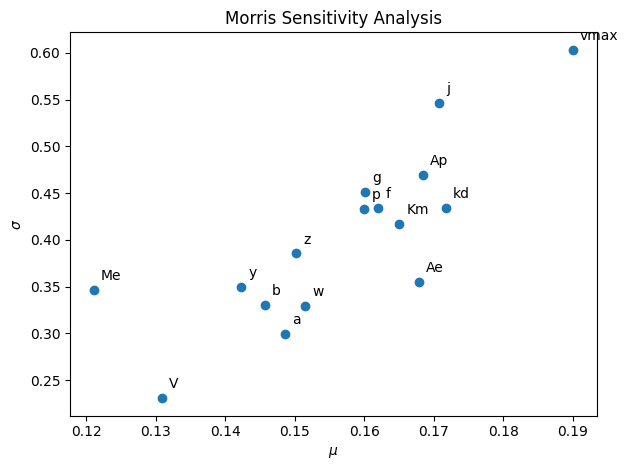

In [ ]:
from run_sensitivity_analyses import aggregate_results, plot_results, scatter_plot

aggregated = aggregate_results(sobol_morris_results)

scatter_plot(results=None, aggregated=aggregated, output_dir="Images/sensitivity_analysis/sobol_morris_aggregated_scatter_plot.png")

In [ ]:
from run_sensitivity_analyses import *

# Define your problem
problem = {
    'num_vars': 16,
    'names': ['p', 'w', 'j', 'kd', 'f', 'Ae', 'Ap', 'u', 'a', 'b', 'd', 'n', 'V', 'vmax', 'Km', 'Me'],
    'bounds': [[8.3e-6, 8.3e-4],      # p: Mup1 production rate – production rates can vary over orders of magnitude due to transcriptional and translational regulation, environmental cues, and promoter strength.
                [10, 100],            # w: pH scale factor – this is a unitless scaling factor, and while its exact biological interpretation may vary, a range of 1 order of magnitude allows for exploratory analysis without being too speculative.
                [10, 1000],           # j: Methionine unbinding rate – binding and unbinding kinetics often vary by 1–2 orders of magnitude depending on temperature, affinity, and conformational state.
                [1000, 90000],        # kd: Dissociation constant – dissociation constants vary widely across protein-ligand systems; range chosen to reflect affinities from high (1 μM) to low (90 μM) binding strength.
                # h is derived from j/kd, so it should not be varied independently – vary j and kd instead
                [0.025, 2.5],         # f: Recycling rate – endosomal recycling rates can vary depending on the type of cargo, regulatory proteins, and metabolic state; 1 order of magnitude captures plausible biological fluctuation.
                [20, 100],            # Ae: Endosomal surface area – endosomal sizes (and hence surface areas) differ based on maturation stage and cell size; this range allows for ~5x variation while remaining realistic for yeast cells.
                [100, 1000],          # Ap: Plasma membrane surface area – reflects variability in yeast cell size; 3–10 μm diameter cells yield surface areas within this range.
                [0.1, 10],            # u: Ubiquitination rate – enzymatic tagging rates are context-dependent, influenced by E3 ligase concentration and substrate type; range spans 2 orders of magnitude.
                [1, 100],             # a: Art1 binding rate – ART protein interactions with transporters can vary widely depending on substrate conformation and signaling state; large range allows for nonlinearity exploration.
                [0.1, 10],            # b: Deubiquitination rate – affected by availability of deubiquitinases and substrate accessibility; same logic as for ubiquitination rate.
                [0.0002, 0.02],       # d: Degradation rate – protein degradation is generally slow, but this range captures variation due to stress conditions, proteasome targeting, or trafficking dynamics.
                [0.01, 1],            # n: Endocytosis rate – strongly regulated and responsive to signaling, nutrient levels, and surface cargo density; up to 100-fold variability is plausible.
                [200, 1000],          # V: Cytoplasmic volume – yeast cells range from ~30 to ~100 fL; cytoplasmic volume varies with cell cycle stage and environmental conditions.
                [1e4, 1e6],           # vmax: Max methionine metabolism rate – reflects possible differences in metabolic enzyme expression, post-translational regulation, and methionine flux capacity.
                [50, 1000],           # Km: Michaelis constant – Km values commonly vary across enzymes and contexts; this range includes both high-affinity (low Km) and low-affinity (high Km) scenarios.
                [0.1, 500],           # Me: Extracellular methionine concentration – based on reported yeast media compositions (from starvation up to rich media); range spans near-zero to saturating conditions.
            ]
}

from scipy.integrate import solve_ivp

# Define your model function
def model_func(X):
    y0 = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    t_span = (0, 50)
    t_eval = np.linspace(*t_span, 10)
    print('...')

    sol = solve_ivp(mup1_model, t_span, y0, args=(X,), t_eval=t_eval)
    print("..")
    return sum(sol.y[:, -1])

# Run parallel sensitivity analyses
results = run_parallel_sensitivity_analyses(
    problem=problem,
    model_func=model_func,
    n_runs=10,
    n_samples=1024
)

# Aggregate results
aggregated = aggregate_results(results)

# # Create plots
# plot_results(aggregated) 